# Predictions on in-memory model


## Setup


In [12]:
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow import keras
from keras import models

In [3]:
print(f"Tensorflow version: {tf.version.VERSION}")

gpus = len(tf.config.list_physical_devices("GPU"))
text_gpus = f"{gpus} GPUs" if gpus > 1 else f"{gpus} GPU"
device_name = tf.test.gpu_device_name()
if gpus > 0:
    print(f"{text_gpus} found at {device_name}")
else:
    raise SystemError("No GPU found")

Tensorflow version: 2.9.1
1 GPU found at /device:GPU:0


In [9]:
MODEL_LOCATION = "gs://practical-ml-vision-book/flowers_5_trained"

FILENAMES = [
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg",
]

## Exported model


In [5]:
!gsutil ls {MODEL_LOCATION}



Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

gs://practical-ml-vision-book/flowers_5_trained/saved_model.pb
gs://practical-ml-vision-book/flowers_5_trained/chkpts/
gs://practical-ml-vision-book/flowers_5_trained/variables/


In [6]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {MODEL_LOCATION}

2022-06-27 06:46:28.223948: F tensorflow/c/experimental/stream_executor/stream_executor.cc:808] Non-OK-status: stream_executor::MultiPlatformManager::RegisterPlatform( std::move(cplatform)) status: INTERNAL: platform is already registered with name: "METAL"


## In-memory model (Python)


In [11]:
serving_fn = models.load_model(MODEL_LOCATION).signatures["serving_default"]
pred = serving_fn(tf.convert_to_tensor(FILENAMES))
print(pred)
print("*********")
print(pred['flower_type_str'].numpy)

{'flower_type_int': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 0, 4, 4])>, 'flower_type_str': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'dandelion', b'dandelion', b'daisy', b'tulips', b'tulips'],
      dtype=object)>, 'probability': <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.61913246, 0.9999844 , 0.995083  , 0.97518575, 0.9549183 ],
      dtype=float32)>}
*********
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'dandelion', b'dandelion', b'daisy', b'tulips', b'tulips'],
      dtype=object)>>


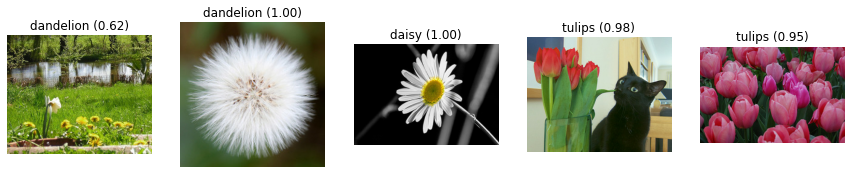

In [13]:
_, ax = plt.subplots(1, 5, figsize=(15, 15))
for idx, (filename, prob, pred_label) in enumerate(
    zip(FILENAMES, pred["probability"].numpy(), pred["flower_type_str"].numpy())
):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    ax[idx].imshow((img.numpy()))
    ax[idx].set_title(f'{pred_label.decode("utf-8")} ({prob:.2f})')
    ax[idx].axis('off')